In [2]:
# source： https://github.com/dome272/VQGAN-pytorch/tree/main
import torch
import torch.nn as nn
import torch.nn.functional as F

class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


# Resnet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)
    




class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A
    



class Encoder(nn.Module):
    def __init__(self, image_channels=1, latent_dim=256):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




#### Encoder output

* a 8*8 square latent space where each node is (1,256)
* elements: groupnorm, resnet, Swish activation func, nonlocal block (attention layer to extract global long distance dependent features)

In [3]:
import argparse
from torchinfo import summary

enc = Encoder()
c = enc(torch.randn(2, 1, 256, 256))

print( 'The encoder architecture is'+'\n{}'.format(
    summary(enc,(1,1,128,128)) 
    ))

The encoder architecture is
Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       [1, 256, 8, 8]            --
├─Sequential: 1-1                             [1, 256, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 128, 128, 128]        1,280
│    └─ResidualBlock: 2-2                     [1, 128, 128, 128]        --
│    │    └─Sequential: 3-1                   [1, 128, 128, 128]        295,680
│    └─ResidualBlock: 2-3                     [1, 128, 128, 128]        --
│    │    └─Sequential: 3-2                   [1, 128, 128, 128]        295,680
│    └─DownSampleBlock: 2-4                   [1, 128, 64, 64]          --
│    │    └─Conv2d: 3-3                       [1, 128, 64, 64]          147,584
│    └─ResidualBlock: 2-5                     [1, 128, 64, 64]          --
│    │    └─Sequential: 3-4                   [1, 128, 64, 64]          295,680
│    └─ResidualBlock: 2-6                   

#### Decoder structure

* Similar to encoder. Adding Upsampling layer

In [4]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class Decoder(nn.Module):
    def __init__(self, image_channels=1, latent_dim=256):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
dnc = Decoder()
c = dnc(torch.randn(2, 256, 8, 8))

print( 'The encoder architecture is'+'\n{}'.format(
    summary(dnc,(2,256,8,8)) 
    ))

The encoder architecture is
Layer (type:depth-idx)                        Output Shape              Param #
Decoder                                       [2, 1, 128, 128]          --
├─Sequential: 1-1                             [2, 1, 128, 128]          --
│    └─Conv2d: 2-1                            [2, 512, 8, 8]            1,180,160
│    └─ResidualBlock: 2-2                     [2, 512, 8, 8]            --
│    │    └─Sequential: 3-1                   [2, 512, 8, 8]            4,721,664
│    └─NonLocalBlock: 2-3                     [2, 512, 8, 8]            262,656
│    │    └─GroupNorm: 3-2                    [2, 512, 8, 8]            1,024
│    │    └─Conv2d: 3-3                       [2, 512, 8, 8]            262,656
│    │    └─Conv2d: 3-4                       [2, 512, 8, 8]            262,656
│    │    └─Conv2d: 3-5                       [2, 512, 8, 8]            262,656
│    └─ResidualBlock: 2-4                     [2, 512, 8, 8]            --
│    │    └─Sequential: 3-6   

#### Vector Quantize codebook

* Embedding layer is codebook parameters to learn during the training process. Once it's learned, the representation is discretized;
* calcualte distance between $z$ and code vectors inside the codebook;
* get the minimum distance indice and query the minimum vector;
* calcualte quantitization loss
* reparameterization trick: $z_q = z + z_q - z$


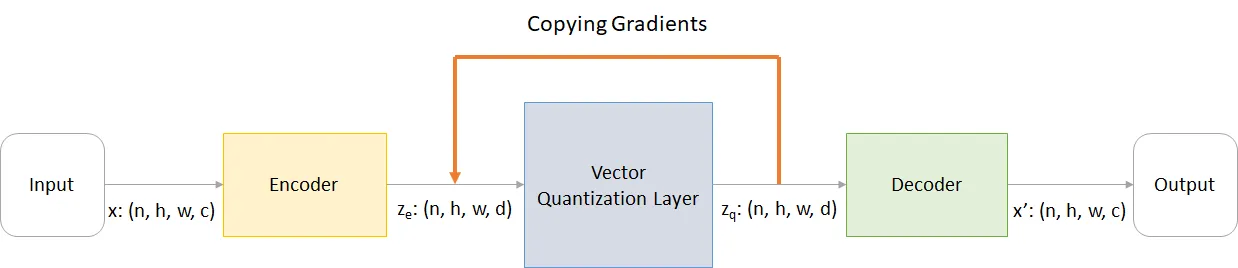

In [10]:
class Codebook(nn.Module):
    def __init__(self, num_codebook_vectors, latent_dim, beta):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = num_codebook_vectors
        self.latent_dim = latent_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        print(z.shape) 
        z_flattened = z.view(-1, self.latent_dim)
        print(z_flattened.shape)

        # distance matrix?
        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        print(d.shape)

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        print(z_q.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)
        print(loss.shape)

        # gradident trick
        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)
        print(z_q.shape)

        return z_q, min_encoding_indices, loss

In [11]:
cb = Codebook(1000, 256, 0.25)
z = torch.randn(2, 256, 8, 8)
z_q,min_encoding_indices,loss = cb(z)

torch.Size([2, 8, 8, 256])
torch.Size([128, 256])
torch.Size([128, 1000])
torch.Size([2, 8, 8, 256])
torch.Size([])
torch.Size([2, 256, 8, 8])
